In [1]:
import random

import coarse_fine_volatility as cfvol
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import torch

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

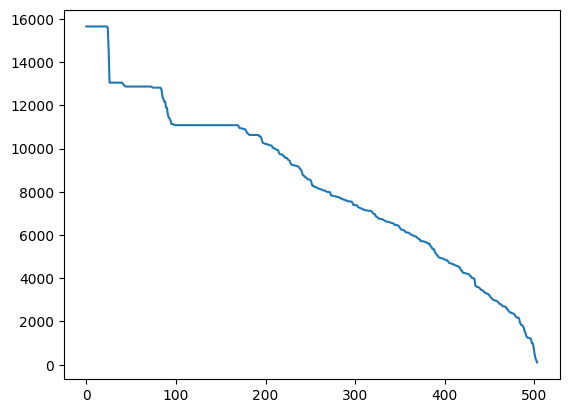

In [4]:
N_STOCKS = 9216
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= N_STOCKS].index

In [5]:
# stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['MSFT']
first_date = real_data.index[-N_STOCKS]
real_data = real_data.loc[first_date:, stocks]
real_data = real_data.loc[:, np.all(~np.isnan(real_data), axis=0)]
assert np.all(~np.isnan(real_data))
print(f"Shape: {real_data.shape}")
print(f"Frist Date {real_data.index[0]:%Y-%m-%d}")
print(f"Last Date {real_data.index[-1]:%Y-%m-%d}")

Shape: (9216, 233)
Frist Date 1987-08-05
Last Date 2024-03-01


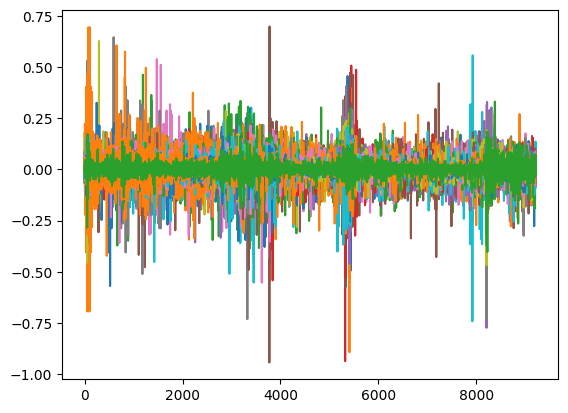

In [6]:
np_data = np.array(real_data)
np_ret = np.log(np_data[1:] / np_data[:-1])
np_ret[np.abs(np_ret) >= 2] = 0  # clean data
np_log_price = np.cumsum(np_ret, axis=0)
plt.plot(np_ret)
plt.show()

alpha : -0.051552063304119385
beta 0.001610422143584467
argmin : 4
r 0.8627597561731649
std alpha : 0.04582333685982034
std beta 0.001672047465946624
std argmin : 4.382396687401261
std r 0.2720271682362181
delta lead lag max 0.06867289457737186


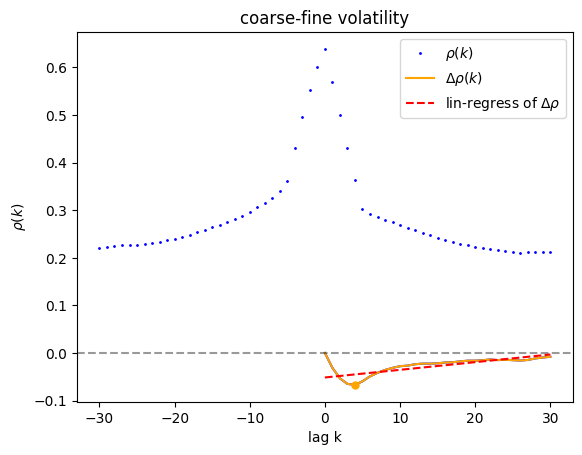

In [11]:
stat = cfvol.coarse_fine_volatility_stats(log_returns=np_ret, tau=5, max_lag=30)
dll, dll_x = np.mean(stat["delta_lead_lag"], axis=1), stat["delta_lead_lag_k"]
ll, ll_x = np.mean(stat["lead_lag"], axis=1), stat["lead_lag_k"]
argmin, alpha, beta, r = stat["argmin"], stat["alpha"], stat["beta"], stat["r"]
std_argmin, std_alpha, std_beta, std_r = (
    stat["argmin_std"],
    stat["alpha_std"],
    stat["beta_std"],
    stat["r_std"],
)
y_lin = alpha + dll_x * beta
plt.gca().set(**cfvol.cf_vol_axes_setting)
plt.plot(dll_x, dll, c="blue")
plt.plot(
    dll_x[argmin], dll[argmin], linestyle="none", marker="o", markersize=5, c="orange"
)
plt.plot(ll_x, ll, **cfvol.cf_vol_plot_setting)
plt.plot(dll_x, dll, **cfvol.lead_lag_plot_setting)
plt.plot(
    dll_x,
    y_lin,
    label="lin-regress of $\Delta \\rho$",
    linestyle="--",
    color="red",
    alpha=1,
)
plt.gca().axhline(y=0, linestyle="--", c="black", alpha=0.4)
print(f"alpha : {alpha}")
print(f"beta {beta}")
print(f"argmin : {argmin}")
print(f"r {r}")
print(f"std alpha : {std_alpha}")
print(f"std beta {std_beta}")
print(f"std argmin : {std_argmin}")
print(f"std r {std_r}")
dll_max = np.max(stat["delta_lead_lag"])
print(f"delta lead lag max {dll_max}")
plt.yscale("linear")
plt.xscale("linear")
plt.legend()
plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/cfv.png")
plt.show()